In [4]:
import re, csv, sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
import pandas as pd

In [5]:
class Cluster(object):
    
    def __init__(self,  name):
        self.name = name
        self.points = []
    
    def add_point(self, point):
        self.points.append(point)
        
    def get_points(self):
        return self.points
    
    def erase(self):
        self.points = []
    
    def get_X(self):
        return [p[0] for p in self.points]
    
    def get_Y(self):
        return [p[1] for p in self.points]
    
    def has(self, point):
        return point in self.points
            
    def __str__(self):
        return "%s: %d points" % (self.name, len(self.points))
    

In [32]:
class DBScanner:
    
    def __init__(self, config):
        self.eps = config['eps']
        self.min_pts = config['min_pts']
        self.clusters = set()
        self.cluster_count = 0
        self.visited = []
        self.color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    def dbscan(self, data, reference_df):
        self.init_params()
        self.data = data

        ## Setting up the plot
        fig = plt.figure()

        axis_proj = 'rectilinear'

        ax = fig.add_subplot(111, projection = axis_proj)
        
        #default noise cluster
        noise = Cluster('Noise', 2)
        self.clusters.add(noise)

        for point in data:
            if point not in self.visited:
                self.visited.append(point)
                neighbour_pts = self.region_query(point, reference_df)
                if len(neighbour_pts) < self.min_pts:
                    noise.add_point(point)
                    for pts in neighbour_pts:
                        reference_df.iloc[int(pts['id']),]['cluster'] = 'Noise'
                     
                else:
                    name = 'cluster-%d' % self.cluster_count
                    new_cluster = Cluster(name, 2)

                    self.cluster_count += 1
                    self.expand_cluster(new_cluster, point, neighbour_pts, reference_df)
                    

                    ax.scatter(new_cluster.get_X(), new_cluster.get_Y(), c = self.color[self.cluster_count % len(self.color)],
                    marker = 'o', label = name)

                    ax.hold(True)
        
        if len(noise.get_points()) != 0:
            ax.scatter(noise.get_X(), noise.get_Y(), marker = 'x', label = noise.name)
        
        print ("Number of clusters found: %d" % self.cluster_count)
        
        ax.hold(False)
        ax.legend(loc='lower left')
        ax.grid(True)
        plt.title(r'DBSCAN Clustering', fontsize=18)
        plt.show()
                    

    def expand_cluster(self, cluster, point, neighbour_pts, reference_df):
        
        cluster.add_point(point)
        reference_df.loc[int(point['id']),'cluster'] = str(cluster)

        #print (neighbour_pts)
        
        for p in neighbour_pts:
            if p not in self.visited:
                self.visited.append(p)
                np = self.region_query(p, reference_df)
                if len(np) >= self.min_pts:
                    for n in np:
                        if n not in neighbour_pts:
                            neighbour_pts.append(n)
                    
                for other_cluster in self.clusters:
                    if not other_cluster.has(p):
                        if not cluster.has(p):
                            cluster.add_point(p)
                            reference_df.loc[int(p['id']),'cluster'] = str(cluster)



                if self.cluster_count == 0:
                    if not cluster.has(p):
                        cluster.add_point(p)
                        reference_df.loc[int(p['id']),'cluster'] = str(cluster)


                        
        self.clusters.add(cluster)
                    
    
    def get_distance(self, from_point, to_point):
        
        p1 = [from_point[k] for k in range(2)]
        p2 = [to_point[k] for k in range(2)]
        return distance.euclidean(p1, p2)

    
    def region_query_2(self, point, reference_df):
        
        result = []
        
        for d_point in self.data: 
            
            for point in reference_df.iloc[int(d_point['id']),]['neighbors'].split(','):
                
                result = result + [d for d in self.data if d['id'] == int(point)]

        return result

        
    def region_query(self, point, reference_df):
        
        result = []
        for d_point in self.data:
            if d_point != point:
                if self.get_distance(d_point, point) <= self.eps:
                    result.append(d_point)
        return result
        
    def init_params(self):
        self.clusters = set()
        self.cluster_count = 0
        self.visited = []


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


Number of clusters found: 4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


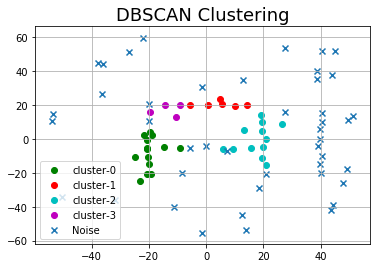

In [38]:
def get_data(config):
    
    reference_df = pd.read_csv('../data/dbscan.csv')
    data = reference_df[['x','y']]
    data = data.reset_index()
    data.columns = ['id', 0, 1]
    
    return data.to_dict('records'), reference_df
    
    
config = {'eps':7.5, 'min_pts': 3, 'dim': 2}

data, reference_df = get_data(config)

dbc = DBScanner(config)

dbc.dbscan(data, reference_df)

In [39]:
[str(i) for i in list(dbc.clusters)]

['cluster-1: 6 points',
 'cluster-2: 12 points',
 'Noise: 44 points',
 'cluster-3: 4 points',
 'cluster-0: 14 points']

In [40]:
reference_df

,cluster,pt,x,y,num_neighbors,neighbors
0,NaN,0,51.418089,13.593610,2,"0,27"
1,NaN,1,39.132318,-4.419204,3,"1,40,75"
2,NaN,2,47.807515,-25.822561,1,2
3,NaN,3,27.699703,53.434193,1,3
4,NaN,4,39.860995,5.676871,3,"4,56,75"
5,NaN,5,-19.891859,10.410274,3,"5,70,74"
6,NaN,6,-0.050283,-4.032522,3,"6,14,42"
7,NaN,7,18.562512,-28.654980,1,7
8,cluster-0: 1 points,8,-14.629904,-4.887040,5,"8,11,60,63,72"
9,NaN,9,38.743881,40.400290,3,"9,33,78"
